In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse


In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize the Data

In [4]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2 Algorithm

## 2.1 Expectation Step 

Compute responsibility (probability of component generating datapoint) :
$$\begin{align}
\ln r_{ik} &= \ln\pi_k + \ln p(\mathbf{x}^{(i)}| z^{(i)}=k, \{\boldsymbol{\mu}_k\}) + C\\
&=\ln\pi_k + \sum_{d=1}^D x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd}) + C
\end{align}$$


Log Likelihood:
$$\ell(\boldsymbol{\pi}, \boldsymbol{\mu}s)=\frac{1}{n}\ln p(\{\mathbf{x}^{(i)}\}_{i=1}^n|\boldsymbol{\pi}, \{\boldsymbol{\mu}_k\}) = \frac{1}{n} \sum_{i=1}^n\ln\left \{ \sum_{k=1}^K \pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)\right \}$$

In [ ]:
def e_step(X, πs, μs, eps=1e-14):
    '''
        πs : k x 1 (priors)
        μs : k x d 
        X  : 500 x d
    '''
    n, D = X.shape
    K = len(πs)
    R = np.zeros((n, K))
    loglik = 0.0

    for i in range(0,n):
        comp1 = np.dot(X[i], np.log(μs + eps).T)
        comp2 = np.dot(X[i], np.log(1 - μs + eps).T)
        sum = np.log(πs + eps) + comp1 + comp2

        print(comp1)
        print(comp2)
        print(np.log(πs + eps))
        print("=========================")

        R[i] = sum  

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)
    
    # Compute average marginal log likelihood 
    loglik = np.sum(log_R_norm) / n        

    return R, loglik

# 2.2 Maximization Step

For $k=1, \ldots, K$:

$$\pi_k = \frac{n_k}{n};\;\; \boldsymbol{\mu}_k = \frac{\sum_{i=1}^n r_{ik} \cdot \mathbf{x}^{(i)}}{n_k},$$


* where $n_k = \sum_{i=1}^n r_{ik}$

In [8]:
def m_step(X, R):
    ## implement here 
    n, d = X.shape # rows are each datapoint, cols are responsibility to each of K clusters

    nk = np.sum(R, axis=0) 
    πs = nk/n
    μs = np.dot(R.T, X)/nk[:, np.newaxis]

    return πs, μs

## 2.3 EM Algorithm Loop

In [21]:
def em_mixberns(X, K, tol = 1e-4, maxIters = 100):
	n,d = X.shape
	## initilisation
	μs = rng.uniform(0, 1, size=(K, d))
	πs = rng.uniform(0, 1, size=(K))

	loglikes = []

	R, loglik = e_step(X, πs, μs)

	loglikes.append(loglik)

	## E-M loop
	for i in range(0, maxIters):

		πs, μs = m_step(X, R)
		R, ll = e_step(X, πs, μs)

		loglikes.append(ll)
	
		if i > 1 and np.abs(loglikes[i] - loglikes[i-1]) < tol : 
			break
	
	zs = np.argmax(R, axis=1)
	return loglikes, πs, μs, zs, R

# 3 Discriminative Predictions & Evaluation

Classify the binary MNIST set

In [23]:
# assume 10 components for digits 0-9
logLiks_em, πs_em, μs_em, zs_em, R_em = em_mixberns(X_mnist_train, 10)

[-200.18210168 -168.18693442 -137.18311941 -149.84276862 -184.02787864
 -175.3524265  -174.3803389  -180.31456003 -172.79170365 -139.39682432]
[-156.14291595 -178.40244507 -189.84314284 -189.61847756 -143.30202969
 -151.81771684 -153.50449161 -149.85327087 -156.53253463 -175.46083691]
[-0.00371521 -2.72432244 -0.72379708 -0.1794654  -0.62967687 -0.42132942
 -1.55213115 -0.50887898 -0.09024784 -0.14509266]
[-187.28451313 -168.73897553 -159.97371134 -168.36336265 -180.12562042
 -180.89142005 -191.77001065 -201.54351507 -196.99766837 -153.42930387]
[-167.99039629 -183.67399941 -192.24076291 -184.50016574 -159.15929167
 -166.66791077 -172.69749211 -169.80382274 -162.08751031 -184.47147237]
[-0.00371521 -2.72432244 -0.72379708 -0.1794654  -0.62967687 -0.42132942
 -1.55213115 -0.50887898 -0.09024784 -0.14509266]
[-119.06859556 -121.2384558  -120.88157498 -134.06252893 -126.5288227
 -112.43259119 -123.00477198 -153.0123693  -137.85299398 -113.9633228 ]
[-131.95090585 -124.24626431 -117.593666

Adjusted rand index:  0.02570098000440002


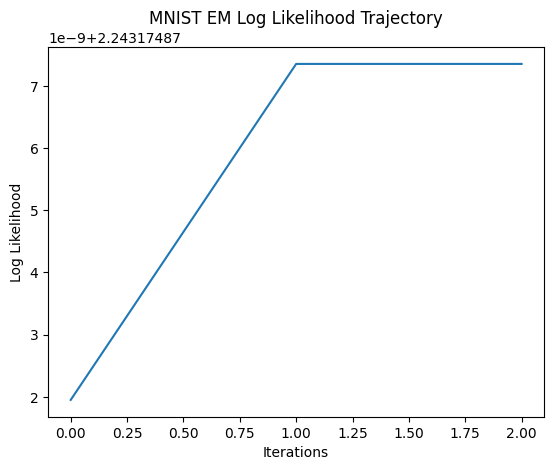

In [24]:
ridx = metrics.adjusted_rand_score(Y_mnist_train, zs_em)

print("Adjusted rand index: ", ridx)

plt.plot(logLiks_em[1:])
plt.title('MNIST EM Log Likelihood Trajectory')
plt.ylabel('Log Likelihood')
plt.xlabel('Iterations')
plt.show()

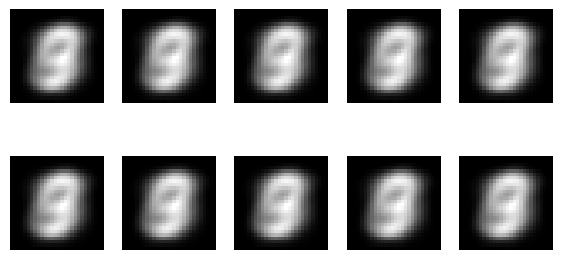

In [25]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = μs_em[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()